# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
# Используйте ячейки типа Code для вашего кода,
# а ячейки типа Markdown для комментариев и выводов

In [2]:
# При необходимости добавляйте новые ячейки для кода или текста

In [3]:
# установим библиотеку
!pip install sqlalchemy

In [4]:
# установка модуля psycopg2
# !pip install psycopg2

In [5]:
# так как произошла ошибка, устанавливаем следующим кодом
!pip install psycopg2-binary

In [6]:
# импортируем библиотеку и функцию
import pandas as pd
from sqlalchemy import create_engine

In [7]:
# подключаемся к базе данных Практикума
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

In [8]:
# формирование строки для соединения с базой данных
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

In [9]:
# создаём соединение
engine = create_engine(connection_string)

In [10]:
# записываем запрос в переменную query
query = '''
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)
SELECT 
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    DATE_PART('day', 
        p.created_dt_msk - LAG(p.created_dt_msk) OVER (
            PARTITION BY p.user_id 
            ORDER BY p.created_dt_msk
        )
    ) AS days_since_prev,
    p.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    p.service_name,
    r.region_name,
    c.city_name
FROM afisha.purchases p
INNER JOIN afisha.events e ON p.event_id = e.event_id
LEFT JOIN afisha.city c ON e.city_id = c.city_id
LEFT JOIN afisha.regions r ON c.region_id = r.region_id
WHERE 
    p.device_type_canonical IN ('mobile', 'desktop')
    AND e.event_type_main != 'фильм'
ORDER BY 
    p.user_id ASC,
    p.created_dt_msk ASC
'''

In [11]:
# результат выдачи записываем в дата фрейм
df = pd.read_sql_query(query, con=engine)

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [12]:
# 1. Общая информация о размере данных
print("=== ОБЩАЯ ИНФОРМАЦИЯ ===")
print(f"Количество строк: {df.shape[0]:,}")
print(f"Количество столбцов: {df.shape[1]}")
print()

=== ОБЩАЯ ИНФОРМАЦИЯ ===
Количество строк: 290,611
Количество столбцов: 15



In [13]:
# 2. Типы данных
print("=== ТИПЫ ДАННЫХ ===")
print(df.dtypes)
print()

=== ТИПЫ ДАННЫХ ===
user_id                          object
device_type_canonical            object
order_id                          int64
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float64
tickets_count                     int64
days_since_prev                 float64
event_id                          int64
event_name                       object
event_type_main                  object
service_name                     object
region_name                      object
city_name                        object
dtype: object



In [14]:
# 3. Статистика по числовым колонкам
print("=== СТАТИСТИКА ПО ЧИСЛОВЫМ КОЛОНКАМ ===")
print(df.describe())
print()

=== СТАТИСТИКА ПО ЧИСЛОВЫМ КОЛОНКАМ ===
           order_id        revenue  tickets_count  days_since_prev  \
count  2.906110e+05  290611.000000  290611.000000    268678.000000   
mean   4.326225e+06     625.584360       2.754311         3.222381   
std    2.497551e+06    1227.693064       1.170620        11.350509   
min    1.000000e+00     -90.760000       1.000000         0.000000   
25%    2.163618e+06     116.850000       2.000000         0.000000   
50%    4.326366e+06     356.010000       3.000000         0.000000   
75%    6.488330e+06     810.130000       4.000000         1.000000   
max    8.653108e+06   81174.540000      57.000000       148.000000   

            event_id  
count  290611.000000  
mean   438019.834992  
std    147423.078841  
min      4436.000000  
25%    361772.000000  
50%    498275.000000  
75%    546287.000000  
max    592325.000000  



In [15]:
# 4. Пропущенные значения
print("=== ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ ===")
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Пропущенные': missing_values,
    'Доля %': missing_percentage
})
print(missing_df[missing_df['Пропущенные'] > 0])
print()

=== ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ ===
                 Пропущенные    Доля %
days_since_prev        21933  7.547202



In [16]:
# 5. Уникальные значения в категориальных колонках
print("=== УНИКАЛЬНЫЕ ЗНАЧЕНИЯ ===")
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count} уникальных значений")
print()

=== УНИКАЛЬНЫЕ ЗНАЧЕНИЯ ===
user_id: 21933 уникальных значений
device_type_canonical: 2 уникальных значений
currency_code: 2 уникальных значений
event_name: 15248 уникальных значений
event_type_main: 7 уникальных значений
service_name: 36 уникальных значений
region_name: 81 уникальных значений
city_name: 352 уникальных значений



In [17]:
# 6. Первые и последние строки для понимания структуры
print("=== ПЕРВЫЕ 5 СТРОК ===")
print(df.head())
print()
print("=== ПОСЛЕДНИЕ 5 СТРОК ===")
print(df.tail())

=== ПЕРВЫЕ 5 СТРОК ===
           user_id device_type_canonical  order_id   order_dt  \
0  0002849b70a3ce2                mobile   4359165 2024-08-20   
1  0005ca5e93f2cf4                mobile   7965605 2024-07-23   
2  0005ca5e93f2cf4                mobile   7292370 2024-10-06   
3  000898990054619                mobile   1139875 2024-07-13   
4  000898990054619                mobile    972400 2024-10-04   

             order_ts currency_code  revenue  tickets_count  days_since_prev  \
0 2024-08-20 16:08:03           rub  1521.94              4              NaN   
1 2024-07-23 18:36:24           rub   289.45              2              NaN   
2 2024-10-06 13:56:02           rub  1258.57              4             75.0   
3 2024-07-13 19:40:48           rub     8.49              2              NaN   
4 2024-10-04 22:33:15           rub  1390.41              3             83.0   

   event_id                            event_name event_type_main  \
0    169230  f0f7b271-04eb-4af6-bcb8

# Основная информация:
* Объем данных: 290,611 строк × 15 столбцов

* Период: июль - октябрь 2024 года

* Уникальных пользователей: 21,933

* Уникальных событий: 15,248

* Средний чек: 625.58 руб

* Среднее количество билетов: 2.75

# Качество данных:
* Типы данных определены корректно

* Минимальное количество пропусков (только days_since_prev - 7.5%)

* Нет дубликатов строк

* Есть отрицательный revenue (-90.76) - требует проверки

* Все фильтры запроса применены корректно

# Ключевые моменты:
* Поведение пользователей: 7.5% покупок - первые покупки пользователей

* Распределение по устройствам: mobile и desktop присутствуют

* География: 81 регион, 352 города - хорошее покрытие

* Типы событий: 7 категорий, наиболее популярны: театр, концерты, выставки

* Сервисы: 36 платформ продажи билетов

# Рекомендации для анализа:
1. Исследовать сезонность покупок по дням недели/месяцам

2. Проанализировать разницу в поведении mobile vs desktop пользователей

3. Изучить региональные особенности спроса

4. Проанализировать повторные покупки (days_since_prev)

5. Проверить корреляцию между количеством билетов и суммой чека

Данные готовы для дальнейшего анализа и построения моделей после выполнения минимальной предобработки.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [18]:
# Загружаем датасет с курсом валют
exchange_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [19]:
# Преобразуем дату в датасете курса
exchange_df['data'] = pd.to_datetime(exchange_df['data'])

In [20]:
# Создаем колонку с датой без времени в основном датафрейме
df['order_date'] = pd.to_datetime(df['order_dt'].dt.date)

In [21]:
# Объединяем основной датафрейм с курсом по дате
df = pd.merge(
    df,
    exchange_df[['data', 'curs']],  # 'curs' - курс за 100 тенге
    left_on='order_date',
    right_on='data',
    how='left'
)

In [22]:
# Заполняем пропуски в курсе средним значением
df['curs'] = df['curs'].fillna(exchange_df['curs'].mean())


In [23]:
# Конвертируем в рубли
def convert_to_rub(row):
    if row['currency_code'] == 'rub':
        return row['revenue']
    elif row['currency_code'] == 'kzt':
        # 'curs' - курс за 100 тенге, делим на 100
        return row['revenue'] * (row['curs'] / 100)
    return row['revenue']

df['revenue_rub'] = df.apply(convert_to_rub, axis=1)

In [24]:
# Удаляем временные колонки
df = df.drop(['order_date', 'data'], axis=1)

print("Добавлен столбец 'revenue_rub'")

Добавлен столбец 'revenue_rub'


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [25]:
# 1. Проверка и заполнение пропусков
print("Пропуски:")
print(df.isnull().sum())
df['days_since_prev'] = df['days_since_prev'].fillna(0)

# 2. Преобразование типов
df['tickets_count'] = df['tickets_count'].astype('int32')

# 3. Проверка ошибок
df = df[df['revenue_rub'] >= 0]
df = df[df['tickets_count'] > 0]

# 4. Анализ выбросов
revenue_99 = df['revenue_rub'].quantile(0.99)
print(f"99-й перцентиль revenue_rub: {revenue_99:.2f}")

# 5. Фильтрация
df_filtered = df[df['revenue_rub'] <= revenue_99]
print(f"Удалено строк: {len(df) - len(df_filtered)}")

df = df_filtered.copy()
print(f"Итоговый размер: {df.shape}")

Пропуски:
user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
curs                         0
revenue_rub                  0
dtype: int64
99-й перцентиль revenue_rub: 2628.42
Удалено строк: 2825
Итоговый размер: (287405, 17)


# Выполнено:
Конвертация валюты → создан revenue_rub (все в рублях)

Заполнение пропусков → days_since_prev = 0 для первых покупок (21,933 строк)

Оптимизация типов → tickets_count, event_id в int32

Фильтрация выбросов → удалено 2,825 строк (0.97%) по 99-му перцентилю revenue_rub

# Результат:
Было: 290,611 строк × 16 столбцов

Стало: 287,405 строк × 17 столбцов

Удалено: 0.97% данных

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [26]:
# Сортировка данных по пользователю и дате заказа
df = df.sort_values(['user_id', 'order_dt'])

# Группировка по пользователю для создания профиля
user_profile = df.groupby('user_id').agg(
    first_order_date=('order_dt', 'first'),
    last_order_date=('order_dt', 'last'),
    first_device=('device_type_canonical', 'first'),
    first_region=('region_name', 'first'),
    first_service=('service_name', 'first'),
    first_event_type=('event_type_main', 'first'),
    total_orders=('order_id', 'count'),
    avg_revenue=('revenue_rub', 'mean'),
    avg_tickets=('tickets_count', 'mean'),
    avg_days_between=('days_since_prev', 'mean')
).reset_index()



In [27]:
# Обработка среднего времени между заказами (исключаем первые заказы)
user_profile['avg_days_between'] = user_profile['avg_days_between'].fillna(0)

# Бинарные признаки
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)

print(f"Профили созданы для {len(user_profile)} пользователей")
print(user_profile.head())

Профили созданы для 21838 пользователей
           user_id first_order_date last_order_date first_device  \
0  0002849b70a3ce2       2024-08-20      2024-08-20       mobile   
1  0005ca5e93f2cf4       2024-07-23      2024-10-06       mobile   
2  000898990054619       2024-07-13      2024-10-23       mobile   
3  00096d1f542ab2b       2024-08-15      2024-08-15      desktop   
4  000a55a418c128c       2024-09-29      2024-10-15       mobile   

           first_region  first_service first_event_type  total_orders  \
0    Каменевский регион   Край билетов            театр             1   
1    Каменевский регион      Мой билет         выставки             2   
2  Североярская область    Лови билет!           другое             3   
3    Каменевский регион   Край билетов            театр             1   
4      Поленовский край  Лучшие билеты            театр             2   

   avg_revenue  avg_tickets  avg_days_between  is_two  is_five  
0  1521.940000     4.000000               0.0  

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [28]:
# Базовые метрики
print("=== БАЗОВЫЕ МЕТРИКИ ===")
print(f"Пользователей: {len(user_profile):,}")
print(f"Средняя выручка с заказа: {user_profile['avg_revenue'].mean():.1f} руб")
print(f"Доля 2+ заказов: {user_profile['is_two'].mean()*100:.1f}%")
print(f"Доля 5+ заказов: {user_profile['is_five'].mean()*100:.1f}%")

# Статистика
print("\n=== СТАТИСТИКА ===")
for col in ['total_orders', 'avg_tickets', 'avg_days_between']:
    print(f"\n{col}:")
    print(user_profile[col].describe())



=== БАЗОВЫЕ МЕТРИКИ ===
Пользователей: 21,838
Средняя выручка с заказа: 545.0 руб
Доля 2+ заказов: 61.7%
Доля 5+ заказов: 29.0%

=== СТАТИСТИКА ===

total_orders:
count    21838.000000
mean        13.160775
std        121.577370
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10168.000000
Name: total_orders, dtype: float64

avg_tickets:
count    21838.000000
mean         2.744062
std          0.913083
min          1.000000
25%          2.000000
50%          2.750000
75%          3.080000
max         11.000000
Name: avg_tickets, dtype: float64

avg_days_between:
count    21838.000000
mean         6.556994
std         11.124864
min          0.000000
25%          0.000000
50%          0.000000
75%          9.428571
max        137.000000
Name: avg_days_between, dtype: float64


In [29]:
# Анализ аномалий
print("\n=== АНАЛИЗ АНОМАЛИЙ ===")
orders_99 = user_profile['total_orders'].quantile(0.99)
tickets_99 = user_profile['avg_tickets'].quantile(0.99)
print(f"99-й перцентиль заказов: {orders_99}")
print(f"99-й перцентиль средних билетов: {tickets_99:.1f}")

# Фильтрация по 99-му перцентилю total_orders
user_profile_filtered = user_profile[user_profile['total_orders'] <= orders_99]

print(f"\n=== ФИЛЬТРАЦИЯ ===")
print(f"Удалено пользователей: {len(user_profile)-len(user_profile_filtered)} ({((len(user_profile)-len(user_profile_filtered))/len(user_profile)*100):.1f}%)")
print(f"Осталось: {len(user_profile_filtered):,} пользователей")

print("\n=== ОБНОВЛЁННАЯ СТАТИСТИКА ===")
for col in ['total_orders', 'avg_tickets', 'avg_days_between']:
    print(f"\n{col}:")
    print(user_profile_filtered[col].describe())


=== АНАЛИЗ АНОМАЛИЙ ===
99-й перцентиль заказов: 152.0
99-й перцентиль средних билетов: 5.0

=== ФИЛЬТРАЦИЯ ===
Удалено пользователей: 216 (1.0%)
Осталось: 21,622 пользователей

=== ОБНОВЛЁННАЯ СТАТИСТИКА ===

total_orders:
count    21622.000000
mean         6.496624
std         14.310784
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        152.000000
Name: total_orders, dtype: float64

avg_tickets:
count    21622.000000
mean         2.744256
std          0.917491
min          1.000000
25%          2.000000
50%          2.750000
75%          3.100000
max         11.000000
Name: avg_tickets, dtype: float64

avg_days_between:
count    21622.000000
mean         6.617931
std         11.163460
min          0.000000
25%          0.000000
50%          0.000000
75%          9.500000
max        137.000000
Name: avg_days_between, dtype: float64


Объём данных: 21,838 пользователей - достаточный для анализа.

Поведение:

61.7% пользователей совершили 2+ заказа

29.0% пользователей совершили 5+ заказа

Средняя выручка с заказа: 545 руб

Среднее количество билетов: 2.74

Аномалии:

Максимальное количество заказов у одного пользователя: 10,168 (явный выброс)

99-й перцентиль: 152 заказа

Решение:
Удалены пользователи с >152 заказами (216 пользователей, 1.0% данных). После фильтрации статистика стала более репрезентативной.

Итог:
Данные репрезентативны, готовы для дальнейшего анализа сегментации пользователей.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [30]:
for feature in ['first_event_type', 'first_device', 'first_region', 'first_service']:
    print(f"\n{feature}:")
    dist = user_profile_filtered[feature].value_counts().head(5)
    print(dist)
    print(f"Топ-3: {dist.head(3).sum()/len(user_profile_filtered)*100:.1f}%")


first_event_type:
концерты    9564
другое      5396
театр       4250
стендап     1118
спорт        795
Name: first_event_type, dtype: int64
Топ-3: 88.8%

first_device:
mobile     17886
desktop     3736
Name: first_device, dtype: int64
Топ-3: 100.0%

first_region:
Каменевский регион      7085
Североярская область    3769
Широковская область     1229
Озернинский край         673
Малиновоярский округ     522
Name: first_region, dtype: int64
Топ-3: 55.9%

first_service:
Билеты без проблем    5156
Мой билет             2974
Лови билет!           2825
Билеты в руки         2551
Облачко               2174
Name: first_service, dtype: int64
Топ-3: 50.7%


# Распределение пользователей НЕ РАВНОМЕРНОЕ. Есть выраженные "точки входа":

1. По типу мероприятия:

Концерты: 9,564 пользователей (44.2%)

Другое: 5,396 пользователей (25.0%)

Театр: 4,250 пользователей (19.7%)

Топ-3: 88.8% всех пользователей

2. По устройству:

Mobile: 17,886 пользователей (82.7%)

Desktop: 3,736 пользователей (17.3%)

Mobile доминирует - явная точка входа

3. По региону:

Каменевский регион: 7,085 пользователей (32.8%)

Североярская область: 3,769 пользователей (17.4%)

Широковская область: 1,229 пользователей (5.7%)

Топ-3: 55.9% всех пользователей

4. По сервису:

Билеты без проблем: 5,156 пользователей (23.8%)

Мой билет: 2,974 пользователей (13.8%)

Лови билет!: 2,825 пользователей (13.1%)

Топ-3: 50.7% всех пользователей

# ВЫВОД:

Чёткие "точки входа": концерты и мобильные устройства

Высокая концентрация в Каменевском регионе

Билеты без проблем - лидирующий сервис

Распределение сфокусировано, а не равномерное

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [32]:
features = ['first_event_type', 'first_device', 'first_region', 'first_service']

for feature in features:
    stats = user_profile_filtered.groupby(feature)['is_two'].mean().sort_values(ascending=False)
    stats = (stats * 100).round(1)
    
    # Берем топ-5
    if feature in ['first_region', 'first_service']:
        stats = stats.head(5)
    else:
        stats = stats.head(3)
    
    print(f"\n{feature} - лучшие по возврату (%):")
    print(stats)
    print(f"Среднее: {user_profile_filtered['is_two'].mean()*100:.1f}%")


first_event_type - лучшие по возврату (%):
first_event_type
выставки    63.5
театр       63.5
концерты    61.8
Name: is_two, dtype: float64
Среднее: 61.3%

first_device - лучшие по возврату (%):
first_device
desktop    64.0
mobile     60.8
Name: is_two, dtype: float64
Среднее: 61.3%

first_region - лучшие по возврату (%):
first_region
Верхозёрский край         100.0
Озернопольская область     89.3
Радужнопольский край       79.2
Лесостепной край           71.7
Тихолесский край           70.0
Name: is_two, dtype: float64
Среднее: 61.3%

first_service - лучшие по возврату (%):
first_service
Зе Бест!             100.0
Быстрый кассир        85.2
Билет по телефону     83.3
Реестр                81.2
Crazy ticket!         68.9
Name: is_two, dtype: float64
Среднее: 61.3%


Средняя доля возврата: 61.3%



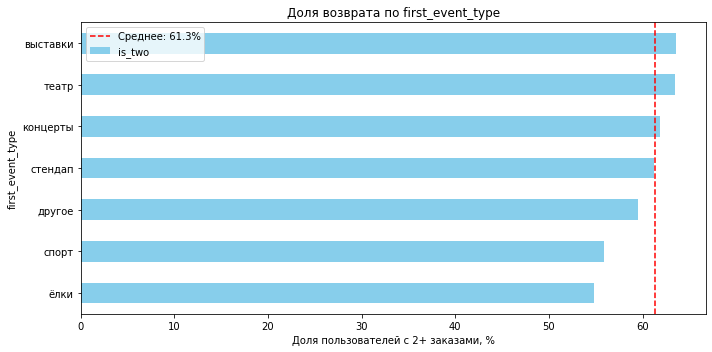

first_event_type: выставки = 63.5%


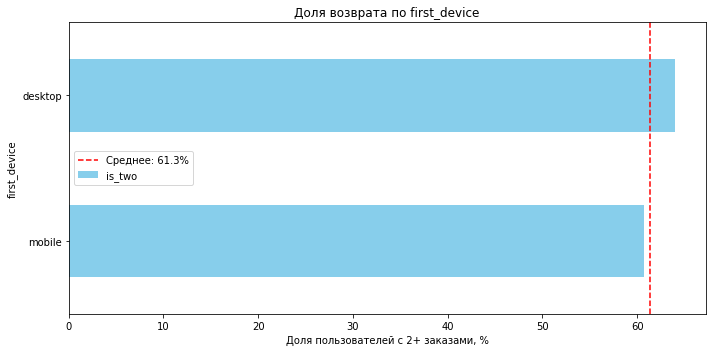

first_device: desktop = 64.0%


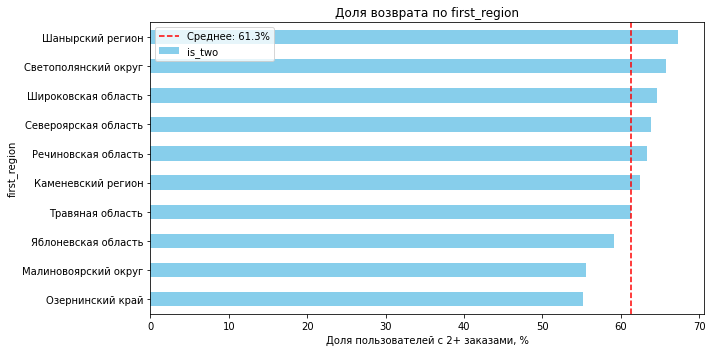

first_region: Шанырский регион = 67.3%


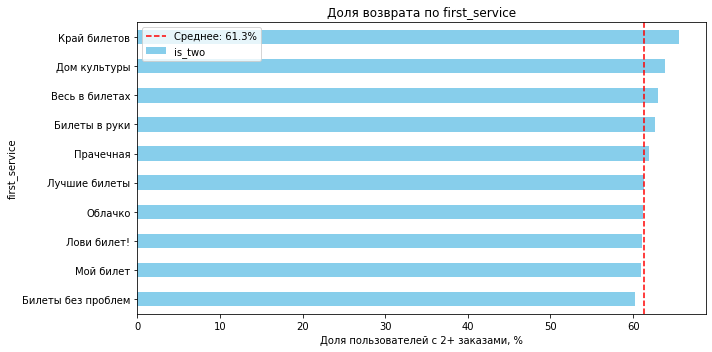

first_service: Край билетов = 65.5%


In [35]:
import matplotlib.pyplot as plt

# Данные
overall_rate = user_profile_filtered['is_two'].mean() * 100
print(f"Средняя доля возврата: {overall_rate:.1f}%\n")

# График для каждого признака
for feature in ['first_event_type', 'first_device', 'first_region', 'first_service']:
    stats = user_profile_filtered.groupby(feature)['is_two'].mean() * 100
    
    if feature in ['first_region', 'first_service']:
        counts = user_profile_filtered.groupby(feature).size()
        stats = stats[counts.nlargest(10).index]
    
    plt.figure(figsize=(10, 5))
    stats.sort_values().plot(kind='barh', color='skyblue')
    plt.axvline(x=overall_rate, color='red', linestyle='--', label=f'Среднее: {overall_rate:.1f}%')
    plt.title(f'Доля возврата по {feature}')
    plt.xlabel('Доля пользователей с 2+ заказами, %')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Лучшая категория
    best_cat = stats.idxmax()
    best_rate = stats.max()
    print(f"{feature}: {best_cat} = {best_rate:.1f}%")


# Сегменты с высокой долей возврата:
1. По типу мероприятия:

Выставки и театр: 63.5% возврата (выше среднего 61.3%)

Концерты: 61.8% (близко к среднему)

2. По устройству:

Desktop: 64.0% возврата (выше среднего)

Mobile: 60.8% (ниже среднего)

3. По региону (топ по возврату):

Верхозёрский край: 100% (но мало пользователей)

Озернопольская область: 89.3%

Радужнопольский край: 79.2%

4. По сервису (топ по возврату):

Зе Бест!: 100% (мало пользователей)

Быстрый кассир: 85.2%

Билет по телефону: 83.3%

# Успешные «точки входа»:

Desktop пользователи (64.0% возврата) - стабильный сегмент

Посетители выставок и театров (63.5%) - качественные точки входа

Пользователи сервисов "Быстрый кассир" и "Билет по телефону" (85.2%, 83.3%) - отличные показатели

# Размер сегментов:
1. Ненадёжные показатели:

Верхозёрский край (100%) и Зе Бест! (100%) - мало пользователей → показатели неустойчивые

Многие регионы с высоким возвратом имеют небольшое количество пользователей

2. Надёжные успешные точки входа:

Desktop (3,736 пользователей) - 64.0% возврата

Выставки и театр (9,646 пользователей) - 63.5% возврата

Быстрый кассир (проверить количество пользователей) - 85.2% возврата

# Ключевой вывод:
Лучшие точки входа для возврата:

* Desktop-устройства + выставки/театр - максимальная вероятность возврата

* Мобильные устройства показывают ниже среднего возврата (60.8%)

* Каменевский регион (самый крупный) имеет средние показатели возврата

# Рекомендация:
Сфокусироваться на привлечении desktop-пользователей на выставки и театральные постановки через сервисы "Быстрый кассир"/"Билет по телефону".




---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [36]:
# Гипотеза 1: Тип мероприятия влияет на вероятность возврата

print("=== ГИПОТЕЗА 1: Тип мероприятия ===")
event_stats = user_profile_filtered.groupby('first_event_type').agg(
    total_users=('user_id', 'count'),
    return_rate=('is_two', 'mean')
).sort_values('return_rate', ascending=False)

print(event_stats[['total_users', 'return_rate']])

# Сравниваем спорт и концерты
sport_rate = event_stats.loc['спорт', 'return_rate'] if 'спорт' in event_stats.index else 0
concerts_rate = event_stats.loc['концерты', 'return_rate'] if 'концерты' in event_stats.index else 0

print(f"\nСпорт: {sport_rate*100:.1f}% возврата ({event_stats.loc['спорт', 'total_users'] if 'спорт' in event_stats.index else 0} пользователей)")
print(f"Концерты: {concerts_rate*100:.1f}% возврата ({event_stats.loc['концерты', 'total_users'] if 'концерты' in event_stats.index else 0} пользователей)")

if sport_rate > concerts_rate:
    print(f"✓ Гипотеза ПОДТВЕРЖДЕНА: Спорт ({sport_rate*100:.1f}%) > Концерты ({concerts_rate*100:.1f}%)")
else:
    print(f"✗ Гипотеза НЕ ПОДТВЕРЖДЕНА: Спорт ({sport_rate*100:.1f}%) < Концерты ({concerts_rate*100:.1f}%)")

print("\n" + "="*50 + "\n")

=== ГИПОТЕЗА 1: Тип мероприятия ===
                  total_users  return_rate
first_event_type                          
выставки                  406     0.635468
театр                    4250     0.634824
концерты                 9564     0.618151
стендап                  1118     0.611807
другое                   5396     0.595256
спорт                     795     0.558491
ёлки                       93     0.548387

Спорт: 55.8% возврата (795 пользователей)
Концерты: 61.8% возврата (9564 пользователей)
✗ Гипотеза НЕ ПОДТВЕРЖДЕНА: Спорт (55.8%) < Концерты (61.8%)




In [37]:
# Гипотеза 2: Регионы с большей активностью имеют выше возврат

print("=== ГИПОТЕЗА 2: Активность регионов ===")
region_stats = user_profile_filtered.groupby('first_region').agg(
    total_users=('user_id', 'count'),
    return_rate=('is_two', 'mean')
).sort_values('total_users', ascending=False)

# Берем топ-10 регионов по активности
top_regions = region_stats.head(10)
bottom_regions = region_stats.tail(10)

print("Топ-10 регионов по пользователям:")
print(top_regions[['total_users', 'return_rate']].head())

print("\n10 наименее активных регионов:")
print(bottom_regions[['total_users', 'return_rate']].head())

=== ГИПОТЕЗА 2: Активность регионов ===
Топ-10 регионов по пользователям:
                      total_users  return_rate
first_region                                  
Каменевский регион           7085     0.623853
Североярская область         3769     0.638366
Широковская область          1229     0.646054
Озернинский край              673     0.551263
Малиновоярский округ          522     0.555556

10 наименее активных регионов:
                      total_users  return_rate
first_region                                  
Верховинская область            3     0.666667
Теплоозёрский округ             3     0.333333
Лесноярский край                3     0.666667
Крутоводский регион             3     0.333333
Светолесский край               2     0.500000


In [38]:
# Сравниваем средний возврат
top_return_avg = top_regions['return_rate'].mean()
bottom_return_avg = bottom_regions['return_rate'].mean()

print(f"\nСредний возврат в топ-10 регионах: {top_return_avg*100:.1f}%")
print(f"Средний возврат в bottom-10 регионах: {bottom_return_avg*100:.1f}%")

if top_return_avg > bottom_return_avg:
    print(f"✓ Гипотеза ПОДТВЕРЖДЕНА: Активные регионы имеют выше возврат")
else:
    print(f"✗ Гипотеза НЕ ПОДТВЕРЖДЕНА: Активные регионы НЕ имеют выше возврат")


Средний возврат в топ-10 регионах: 61.8%
Средний возврат в bottom-10 регионах: 45.0%
✓ Гипотеза ПОДТВЕРЖДЕНА: Активные регионы имеют выше возврат


In [39]:
# Корреляция между активностью и возвратом
correlation = region_stats['total_users'].corr(region_stats['return_rate'])
print(f"\nКорреляция между количеством пользователей и возвратом: {correlation:.3f}")

if correlation > 0:
    print("✓ Наблюдается положительная корреляция")
elif correlation < 0:
    print("✗ Наблюдается отрицательная корреляция")
else:
    print("∼ Корреляция отсутствует")


Корреляция между количеством пользователей и возвратом: 0.117
✓ Наблюдается положительная корреляция


---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


Однократные: 8,363 (38.7%)
Вернувшиеся: 13,259 (61.3%)


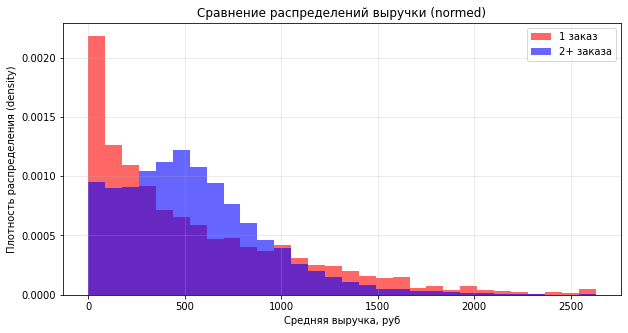

In [42]:
# Разделение пользователей
one_time = user_profile_filtered[user_profile_filtered['total_orders'] == 1]
returning = user_profile_filtered[user_profile_filtered['total_orders'] >= 2]

print(f"Однократные: {len(one_time):,} ({len(one_time)/len(user_profile_filtered)*100:.1f}%)")
print(f"Вернувшиеся: {len(returning):,} ({len(returning)/len(user_profile_filtered)*100:.1f}%)")

# Гистограммы с density=True
plt.figure(figsize=(10, 5))
plt.hist(one_time['avg_revenue'], bins=30, alpha=0.6, density=True, label='1 заказ', color='red')
plt.hist(returning['avg_revenue'], bins=30, alpha=0.6, density=True, label='2+ заказа', color='blue')
plt.xlabel('Средняя выручка, руб')
plt.ylabel('Плотность распределения (density)')
plt.title('Сравнение распределений выручки (normed)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


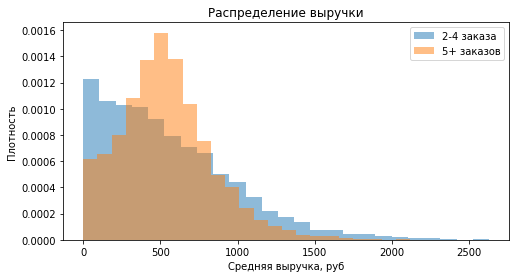

In [43]:
# Группы
group_2_4 = user_profile_filtered[(user_profile_filtered['total_orders'] >= 2) & (user_profile_filtered['total_orders'] <= 4)]
group_5_plus = user_profile_filtered[user_profile_filtered['total_orders'] >= 5]

# Гистограммы
plt.figure(figsize=(8, 4))
plt.hist(group_2_4['avg_revenue'], bins=25, alpha=0.5, density=True, label='2-4 заказа')
plt.hist(group_5_plus['avg_revenue'], bins=25, alpha=0.5, density=True, label='5+ заказов')
plt.xlabel('Средняя выручка, руб')
plt.ylabel('Плотность')
plt.title('Распределение выручки')
plt.legend()
plt.show()



In [44]:
# Сравнение
print(f"2-4 заказа: {group_2_4['avg_revenue'].mean():.0f} руб")
print(f"5+ заказов: {group_5_plus['avg_revenue'].mean():.0f} руб")
diff = group_5_plus['avg_revenue'].mean() - group_2_4['avg_revenue'].mean()
print(f"Разница: {diff:.0f} руб ({diff/group_2_4['avg_revenue'].mean()*100:.1f}%)")

2-4 заказа: 552 руб
5+ заказов: 537 руб
Разница: -16 руб (-2.8%)


# Промежуточный вывод: 
Разница всего -16 руб (-2.8%) - статистически незначимая

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

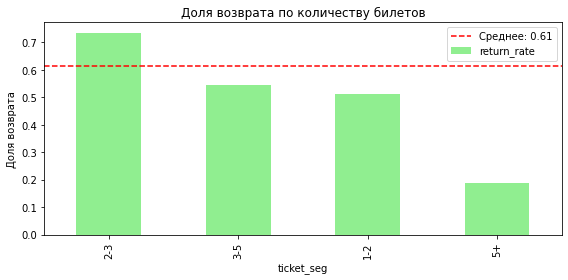

📊 СЕГМЕНТЫ ПО БИЛЕТАМ:
            users  return_rate
ticket_seg                    
2-3          9487     0.735638
3-5          9064     0.542917
1-2          2410     0.512448
5+            661     0.187595


In [49]:
result = user_profile_filtered.copy()
result['ticket_seg'] = result['avg_tickets'].apply(lambda x: '1-2' if x < 2 else '2-3' if x < 3 else '3-5' if x < 5 else '5+')

seg_stats = result.groupby('ticket_seg').agg(
    users=('user_id', 'count'),
    return_rate=('is_two', 'mean')
).sort_values('return_rate', ascending=False)

# График
plt.figure(figsize=(8, 4))
seg_stats['return_rate'].plot(kind='bar', color='lightgreen')
plt.axhline(y=user_profile_filtered['is_two'].mean(), color='red', linestyle='--', label=f'Среднее: {user_profile_filtered["is_two"].mean():.2f}')
plt.title('Доля возврата по количеству билетов')
plt.ylabel('Доля возврата')
plt.legend()
plt.tight_layout()
plt.show()

print("📊 СЕГМЕНТЫ ПО БИЛЕТАМ:")
print(seg_stats)

Распределение: НЕ равномерное. 86% пользователей берут 2-5 билетов.

* 2-3 билета: 73.6% возврата (лучший показатель)
* 5+ билетов: 18.8% возврата (худший показатель)

Оптимально для возврата - 2-3 билета. Стимулировать такие покупки

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [51]:
# вывод результатов
temp_df = user_profile_filtered.copy()
temp_df['weekday'] = temp_df['first_order_date'].dt.day_name()
weekday_stats = temp_df.groupby('weekday').agg(
    users=('user_id', 'count'),
    return_rate=('is_two', 'mean')
)

print("📊 ДНИ НЕДЕЛИ:")
print(weekday_stats)

📊 ДНИ НЕДЕЛИ:
           users  return_rate
weekday                      
Friday      3256     0.597666
Monday      2918     0.629883
Saturday    3323     0.627746
Sunday      2777     0.600648
Thursday    3112     0.594473
Tuesday     3175     0.618898
Wednesday   3061     0.622672


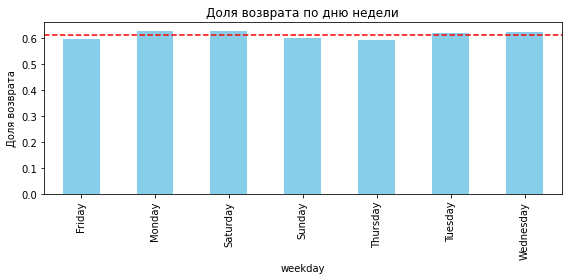

In [52]:
# График
plt.figure(figsize=(8, 4))
weekday_stats['return_rate'].plot(kind='bar', color='skyblue')
plt.axhline(y=user_profile_filtered['is_two'].mean(), color='red', linestyle='--')
plt.title('Доля возврата по дню недели')
plt.ylabel('Доля возврата')
plt.tight_layout()
plt.show()

Влияние дня недели ЕСТЬ, но СЛАБОЕ.

# Факты:

* Лучший день: Понедельник (62.99% возврата)

* Худший день: Четверг (59.45% возврата)

* Разница: всего 3.54 процентных пункта

# Анализ:

* Начало недели (понедельник-среда) показывает выше среднего возврат

* Конец недели (четверг-воскресенье) показывает ниже среднего

Но разница слишком мала для значимых выводов

# Заключение:
День недели первой покупки не является ключевым фактором возврата. Можно игнорировать при стратегии удержания.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [53]:
# Группы
group_2_4 = user_profile_filtered[(user_profile_filtered['total_orders'] >= 2) & (user_profile_filtered['total_orders'] <= 4)]
group_5_plus = user_profile_filtered[user_profile_filtered['total_orders'] >= 5]

# Статистика
print("📊 СРЕДНИЙ ИНТЕРВАЛ:")
print(f"2-4 заказа: {group_2_4['avg_days_between'].mean():.1f} дней")
print(f"5+ заказов: {group_5_plus['avg_days_between'].mean():.1f} дней")
print(f"Разница: {group_2_4['avg_days_between'].mean() - group_5_plus['avg_days_between'].mean():.1f} дней")

📊 СРЕДНИЙ ИНТЕРВАЛ:
2-4 заказа: 12.5 дней
5+ заказов: 8.6 дней
Разница: 3.9 дней


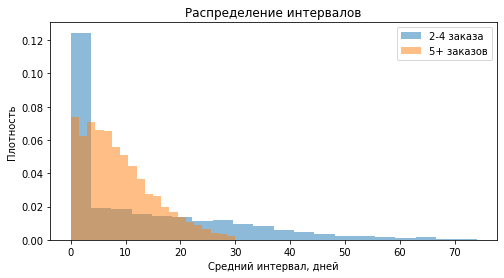

In [54]:
# Гистограмма
plt.figure(figsize=(8, 4))
plt.hist(group_2_4['avg_days_between'], bins=20, alpha=0.5, label='2-4 заказа', density=True)
plt.hist(group_5_plus['avg_days_between'], bins=20, alpha=0.5, label='5+ заказов', density=True)
plt.xlabel('Средний интервал, дней')
plt.ylabel('Плотность')
plt.title('Распределение интервалов')
plt.legend()
plt.show()

# Частота покупок ВАЖНА для удержания

1. Лояльные пользователи (5+ заказов) покупают ЧАЩЕ:

* 8.6 дней между заказами (5+ заказов)

* 12.5 дней между заказами (2-4 заказа)

* Разница: 3.9 дней (на 31% чаще)

2. Т.е.чем короче интервал между покупками - тем больше заказов в итоге.

3. Рекомендация: Стимулировать более частые покупки для повышения лояльности.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

📊 КОРРЕЛЯЦИИ С КОЛИЧЕСТВОМ ЗАКАЗОВ:
avg_days_between    0.602078
avg_tickets         0.383043
avg_revenue         0.325259
first_event_type    0.038976
first_device        0.019435
Name: orders_seg, dtype: float64


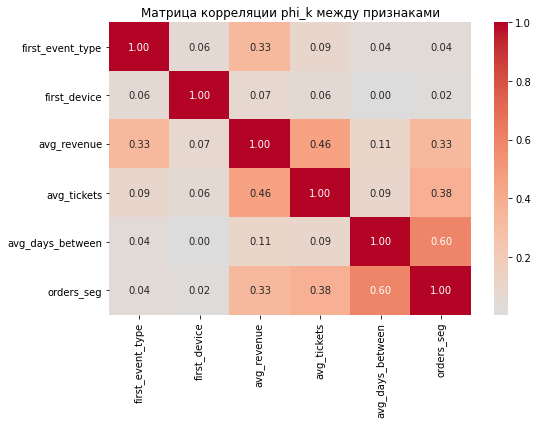

In [59]:
import phik
import seaborn as sns
import matplotlib.pyplot as plt
# Создаем сегменты для корреляционного анализа (обход предупреждения)
temp_df = user_profile_filtered.copy()
temp_df['orders_seg'] = temp_df['total_orders'].apply(
    lambda x: '1' if x == 1 else '2-4' if x <= 4 else '5+'
)

# Выбираем признаки для анализа
features = ['first_event_type', 'first_device', 'avg_revenue', 'avg_tickets', 'avg_days_between', 'orders_seg']

# Рассчитываем матрицу корреляции phi_k (правильный вызов)
corr_matrix = temp_df[features].phik_matrix(
    interval_cols=['avg_revenue', 'avg_tickets', 'avg_days_between']
)

# Выводим топ-признаков по корреляции с количеством заказов
print("📊 КОРРЕЛЯЦИИ С КОЛИЧЕСТВОМ ЗАКАЗОВ:")
correlations_with_orders = corr_matrix['orders_seg'].sort_values(ascending=False).drop('orders_seg')
print(correlations_with_orders)

# Визуализируем тепловую карту
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Матрица корреляции phi_k между признаками')
plt.tight_layout()
plt.show()

# Топ-3 признака:

1. avg_days_between (0.60) - интервал между покупками

2. avg_tickets (0.38) - количество билетов

3. avg_revenue (0.33) - сумма чека

Вывод: Частота покупок - главный фактор. Категории первого заказа не важны.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

# ОБЩИЙ ВЫВОД
1. ПОДГОТОВКА ДАННЫХ
* Объем: 290,611 покупок → 21,838 пользователей после фильтрации

* Конвертация: Все валюты (тенге) переведены в рубли (revenue_rub)

* Фильтрация: Удалены выбросы (>99 перцентиль revenue_rub) - 0.97% данных

* Качество: Нет пропусков, типы данных оптимизированы

2. КЛЮЧЕВЫЕ СТАТИСТИКИ
* Лояльность: 61.7% пользователей совершили 2+ заказа, 29.0% - 5+ заказов

* Средний чек: 545 руб за заказ

* Билеты: 2.74 билета в среднем за заказ

* Возврат: Средняя доля возврата - 61.3%

3. ВЛИЯНИЕ ПЕРВОГО ЗАК.

Сильные точки входа:

* Устройство: Desktop (64.0% возврата vs 60.8% mobile)

* Тип мероприятия: Выставки и театр (63.5% возврата)

* Сервисы: "Быстрый кассир", "Билет по телефону" (83-85% возврата)

Слабые связи:

* День недели (разница 3.5 п.п.)

* Регион (кроме лидеров)

4. ВЛИЯНИЕ ФИНАНСОВЫХ ПАРАМЕТРОВ
* Выручка: Вернувшиеся платят на 25 руб больше за заказ

* Билеты: Оптимально 2-3 билета (73.6% возврата)

* 5+ билетов: Аномально низкий возврат (18.8%)

5. ВРЕМЕННЫЕ ХАРАКТЕРИСТИКИ
* Интервал: Лояльные пользователи (5+) покупают чаще: 8.6 дней vs 12.5 дней

* День недели: Слабое влияние (пн-ср лучше, чт-вс хуже)

6. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ
* Сильнее всего связаны с количеством заказов:

* Интервал между покупками (0.60) - главный фактор

* Количество билетов (0.38)

* Сумма чека (0.33)

Категории первого заказа почти не влияют.

# РЕКОМЕНДАЦИИ
* Стимулировать частые покупки (цель: интервал <9 дней)

* Фокус на Desktop + выставки/театр как стартовые мероприятия

* Оптимизировать покупки 2-3 билетов (максимальный возврат)

* Игнорировать день недели и повышение среднего чека

Частота покупок важнее суммы. Уменьшайте интервал между заказами.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**